# Regional-residual separation of gravity data

This code uses the potential-field data computed in the notebook `aula_5d_dados_sinteticos_grav.ipynb`.

### Things we have to import

In [1]:
import numpy as np

In [2]:
from numpy.polynomial.polynomial import polyvander2d

In [3]:
import matplotlib.pyplot as plt

In [4]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [5]:
import time

In [6]:
import pickle

In [7]:
from gravmag import data_structures, utils, aux_vedo, constants, check
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf

In [8]:
import vedo

In [9]:
# set the backend for vedo
vedo.settings.default_backend= 'vtk'
#vedo.settings.default_backend= '2d'

In [10]:
def model_cut(model, pmin, pmax):
    check.are_rectangular_prisms(model)
    check.is_integer(x=pmin, positive=True, include_zero=True)
    check.is_integer(x=pmax, positive=True, include_zero=True)
    if pmin >= pmax:
        raise ValueError('pmin must be greater than pmax')
    nprisms = model['x1'].size
    if pmin >= nprisms:
        raise ValueError('pmin must be smaller than num. of model prisms')
    if pmax >= nprisms:
        raise ValueError('pmax must be smaller than num. of model prisms')
    selected_model = dict()
    for element in model.keys():
        selected_model[element] = model[element][pmin:pmax+1]
    return selected_model

### Load the model

In [11]:
model = pickle.load(open('aula_5d/synthetic_bodies.pickle', 'rb'))

In [12]:
# model properties
print("(xmin, xmax) = ({:.3f}, {:.3f}) m".format(model['prisms']['x1'].min(), model['prisms']['x2'].max()))
print("(ymin, ymax) = ({:.3f}, {:.3f}) m".format(model['prisms']['y1'].min(), model['prisms']['y2'].max()))
print("(top min, top max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z1'].min(), model['prisms']['z1'].max()))
print("(bottom min, bottom max) = ({:.3f}, {:.3f}) m".format(model['prisms']['z2'].min(), model['prisms']['z2'].max()))
print("number of prisms: {}".format(model['prisms']['x1'].size))

(xmin, xmax) = (-7231.854, 6949.434) m
(ymin, ymax) = (-5904.876, 8243.995) m
(top min, top max) = (0.000, 1000.000) m
(bottom min, bottom max) = (106.752, 1500.000) m
number of prisms: 305


### Load the data points

In [13]:
data_points = pickle.load(open('aula_5d/data_points.pickle', 'rb'))

In [14]:
# number of points along x and y
print('n. data = {}'.format(data_points['shape'][0]*data_points['shape'][1]))

# grid spacing
data_dx, data_dy = data_structures.grid_xy_spacing(area=data_points['area'], shape=data_points['shape'])
print('dx = {:.3f} m | dy = {:.3f} m'.format(data_dx, data_dy))

n. data = 4900
dx = 202.899 m | dy = 202.899 m


In [15]:
X, Y = data_structures.grid_xy_to_full_matrices_view(
    x=data_points['grid']['x'],
    y=data_points['grid']['y'],
    shape=data_points['shape']
)

### Load the residual data (gravity disturbance)

In [16]:
gravity_data = pickle.load(open('aula_5d/gravity_data.pickle', 'rb'))

### Simulate a regional field

In [17]:
# coefficients of the polynoimial defining the regional field
c0 = 0.0
c1 = -0.003
c2 = 0.006
c3 = 0.0000001
c4 = 0.0000001

# horizontal coordinates of the center
xc = (data_points['grid']['x'][0] + data_points['grid']['x'][-1]) / 2
yc = (data_points['grid']['y'][0] + data_points['grid']['y'][-1]) / 2

# regional field
regional = data_structures.grid_xy_full_matrix_to_flatten(
    grid=c0 + c1*(X - xc) + c2*(Y - yc) + c3*(X - xc)**2 + c4*(Y - yc)**2,
    grid_orientation=gravity_data['grid_orientation']
)

### Resultant data

In [18]:
resultant = gravity_data['gz'] + regional

### Plot the simulated data

In [19]:
names = ['residual', 'regional', 'resultant']
labels = ['(a)', '(b)', '(c)']

In [20]:
mosaic_elements = ['a', 'b', 'c']

In [21]:
ranges = np.max(np.abs([gravity_data['gz'], regional, resultant]))

In [22]:
color = 'k'#3*(0.4,)

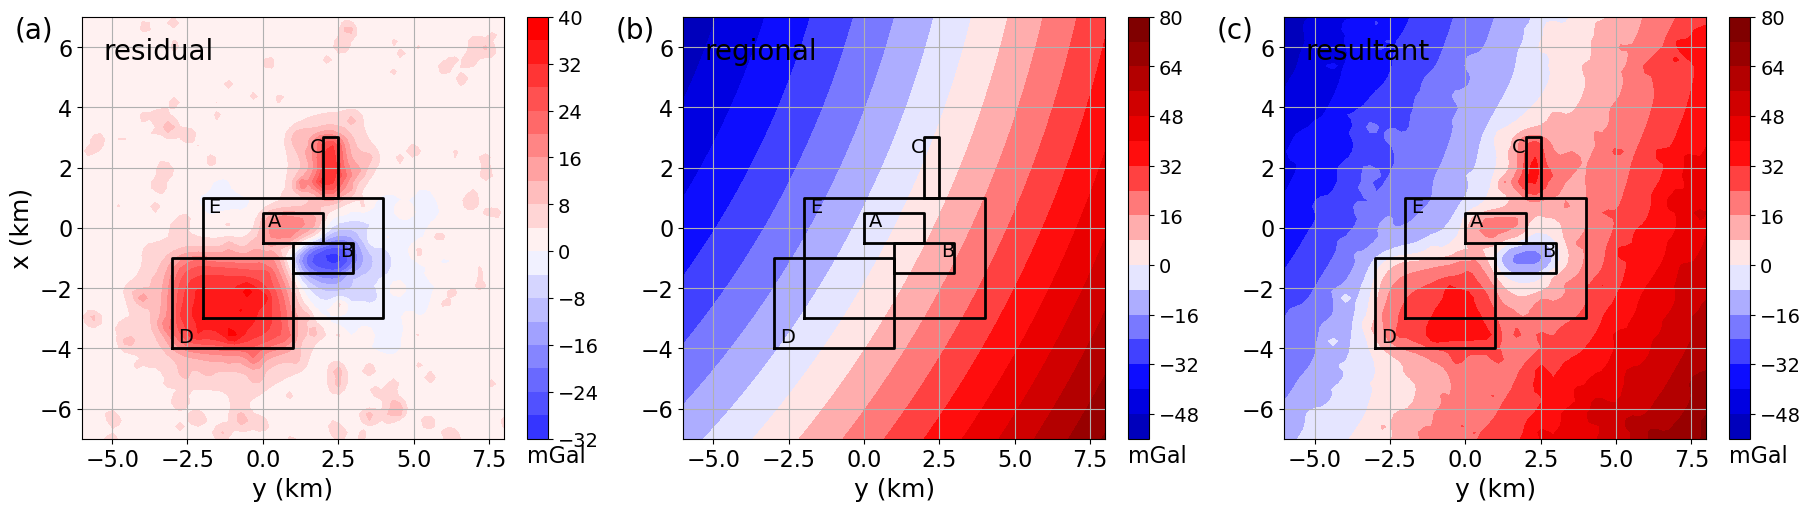

In [23]:
fig = plt.figure(layout= 'constrained', figsize=(18,5))
mosaic = fig.subplot_mosaic('''
                            abc
                            ''')
for (element, field, name, label) in zip(
    mosaic_elements, 
    [gravity_data['gz'], regional, resultant], 
    names, 
    labels
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=gravity_data['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges, vmax=ranges)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(name, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)

for element in ['a','b','c']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()

### Ajuste polinomial simples

In [24]:
A = polyvander2d(
    x=data_structures.grid_xy_full_matrix_to_flatten(
        grid=Y,
        grid_orientation=gravity_data['grid_orientation']
    ),
    y=data_structures.grid_xy_full_matrix_to_flatten(
        grid=X,
        grid_orientation=gravity_data['grid_orientation']
    ),
    deg=[2,2]
)

In [25]:
p1 = np.linalg.solve(A.T@A, A.T@resultant)

In [26]:
estimated_regional1 = A@p1

In [27]:
estimated_residual1 = resultant - estimated_regional1

### Plot the estimated data

In [28]:
names = [
    'regional', 'est. regional', 'difference',
    'residual', 'est. residual', 'difference'
]
labels = [
    '(a)', '(b)', '(c)',
    '(d)', '(e)', '(f)'
]

In [29]:
mosaic_elements = [
    'a', 'b', 'c', 
    'd', 'e', 'f'
]

In [30]:
color = 'k'#3*(0.4,)

In [31]:
ranges_regional1 = np.max(np.abs([regional, estimated_regional1]))
ranges_residual1 = np.max(np.abs([gravity_data['gz'], estimated_residual1]))

ranges = [
    ranges_regional1, ranges_regional1, np.max(np.abs(estimated_regional1 - regional)),
    ranges_residual1, ranges_residual1, np.max(np.abs(estimated_residual1 - gravity_data['gz'])),
]

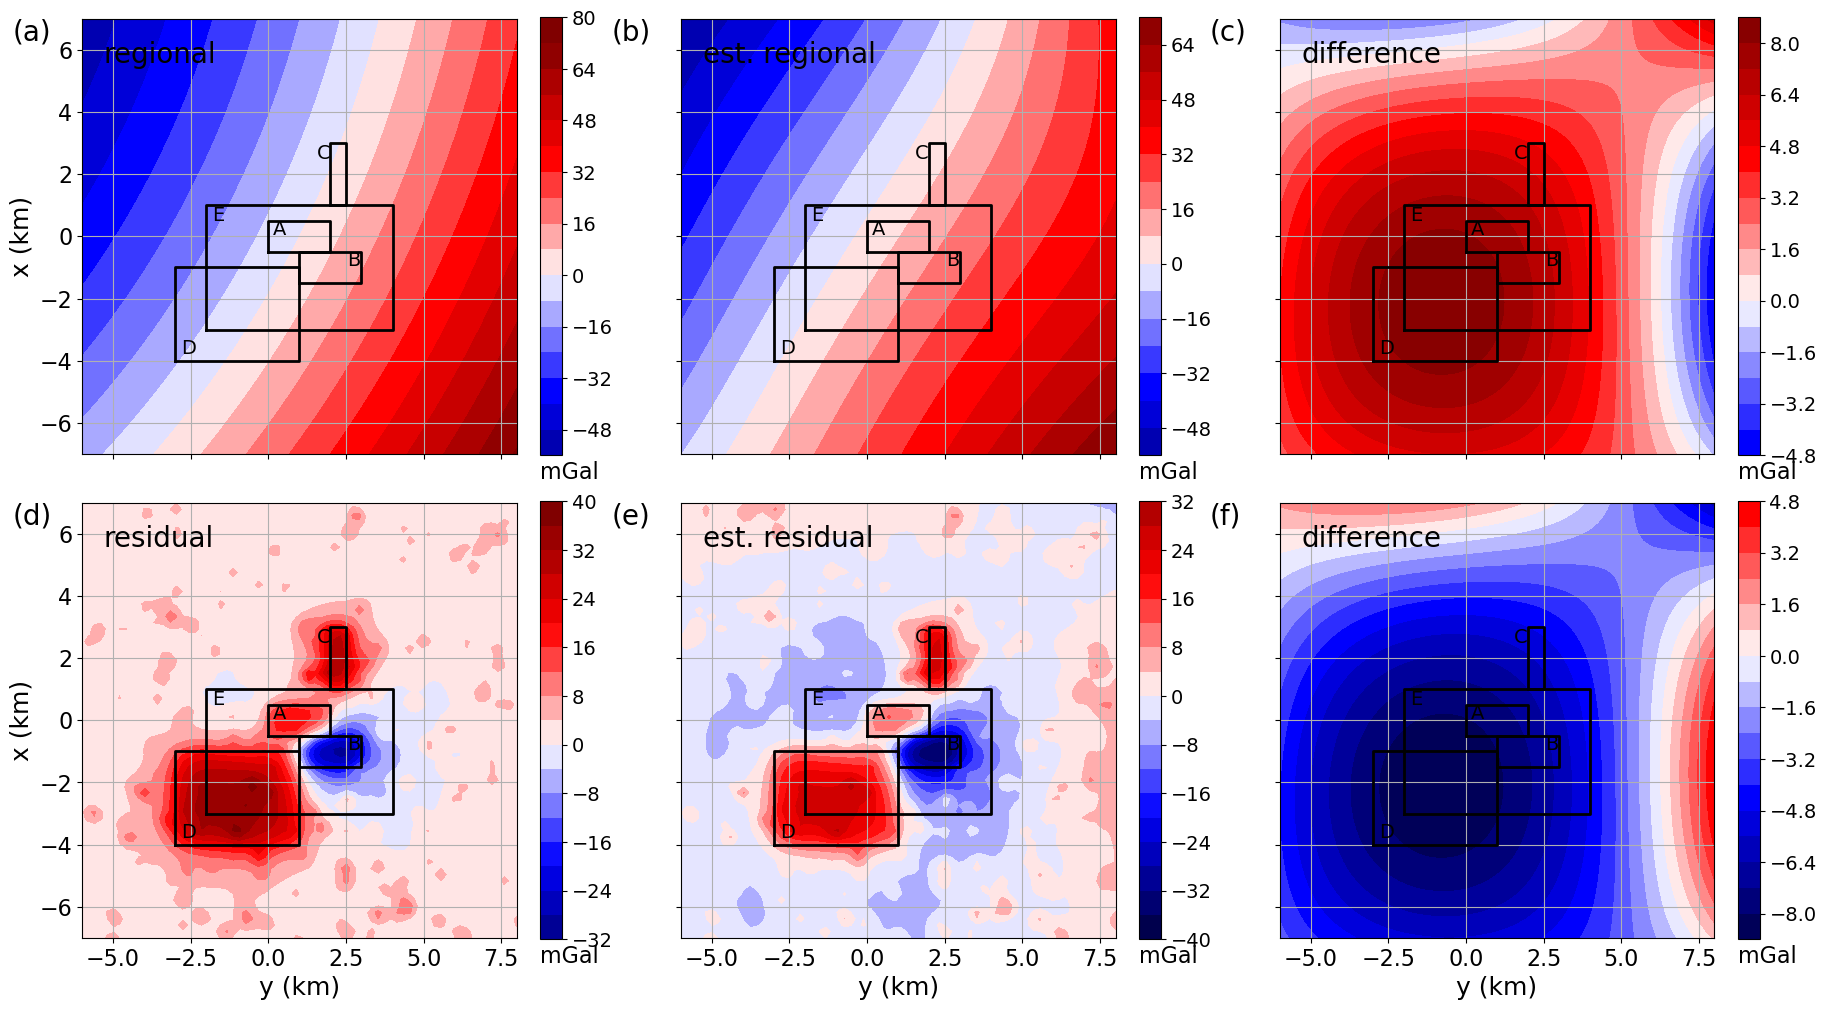

In [32]:
fig = plt.figure(layout= 'constrained', figsize=(18,10))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''', sharex=True, sharey=True)

for (element, field, name, label, ranges_field) in zip(
    mosaic_elements, 
    [
        regional, estimated_regional1, estimated_regional1 - regional,
        gravity_data['gz'], estimated_residual1, estimated_residual1 - gravity_data['gz']
    ], 
    names, 
    labels,
    ranges
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=gravity_data['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_field, vmax=ranges_field)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(name, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a', 'd']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)

for element in ['d','e','f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()

### Ajuste polinomial robusto

In [41]:
iteracoes = 20

p2 = p1.copy()
estimated_regional2 = estimated_regional1.copy()

for i in range(iteracoes):
    r = resultant - estimated_regional2
    s = np.median(r)
    #W = np.diag(np.exp(-((0.6745*r/s)**2.)))
    W = np.diag(1./np.abs(r + 1.e-10))
    W = A.T@W
    p2 = np.linalg.solve(W@A, W@resultant)
    estimated_regional2 = A@p2

In [42]:
estimated_residual2 = resultant - estimated_regional2

In [43]:
ranges_regional2 = np.max(np.abs([regional, estimated_regional2]))
ranges_residual2 = np.max(np.abs([gravity_data['gz'], estimated_residual2]))

ranges = [
    ranges_regional2, ranges_regional2, np.max(np.abs(estimated_regional2 - regional)),
    ranges_residual2, ranges_residual2, np.max(np.abs(estimated_residual2 - gravity_data['gz'])),
]

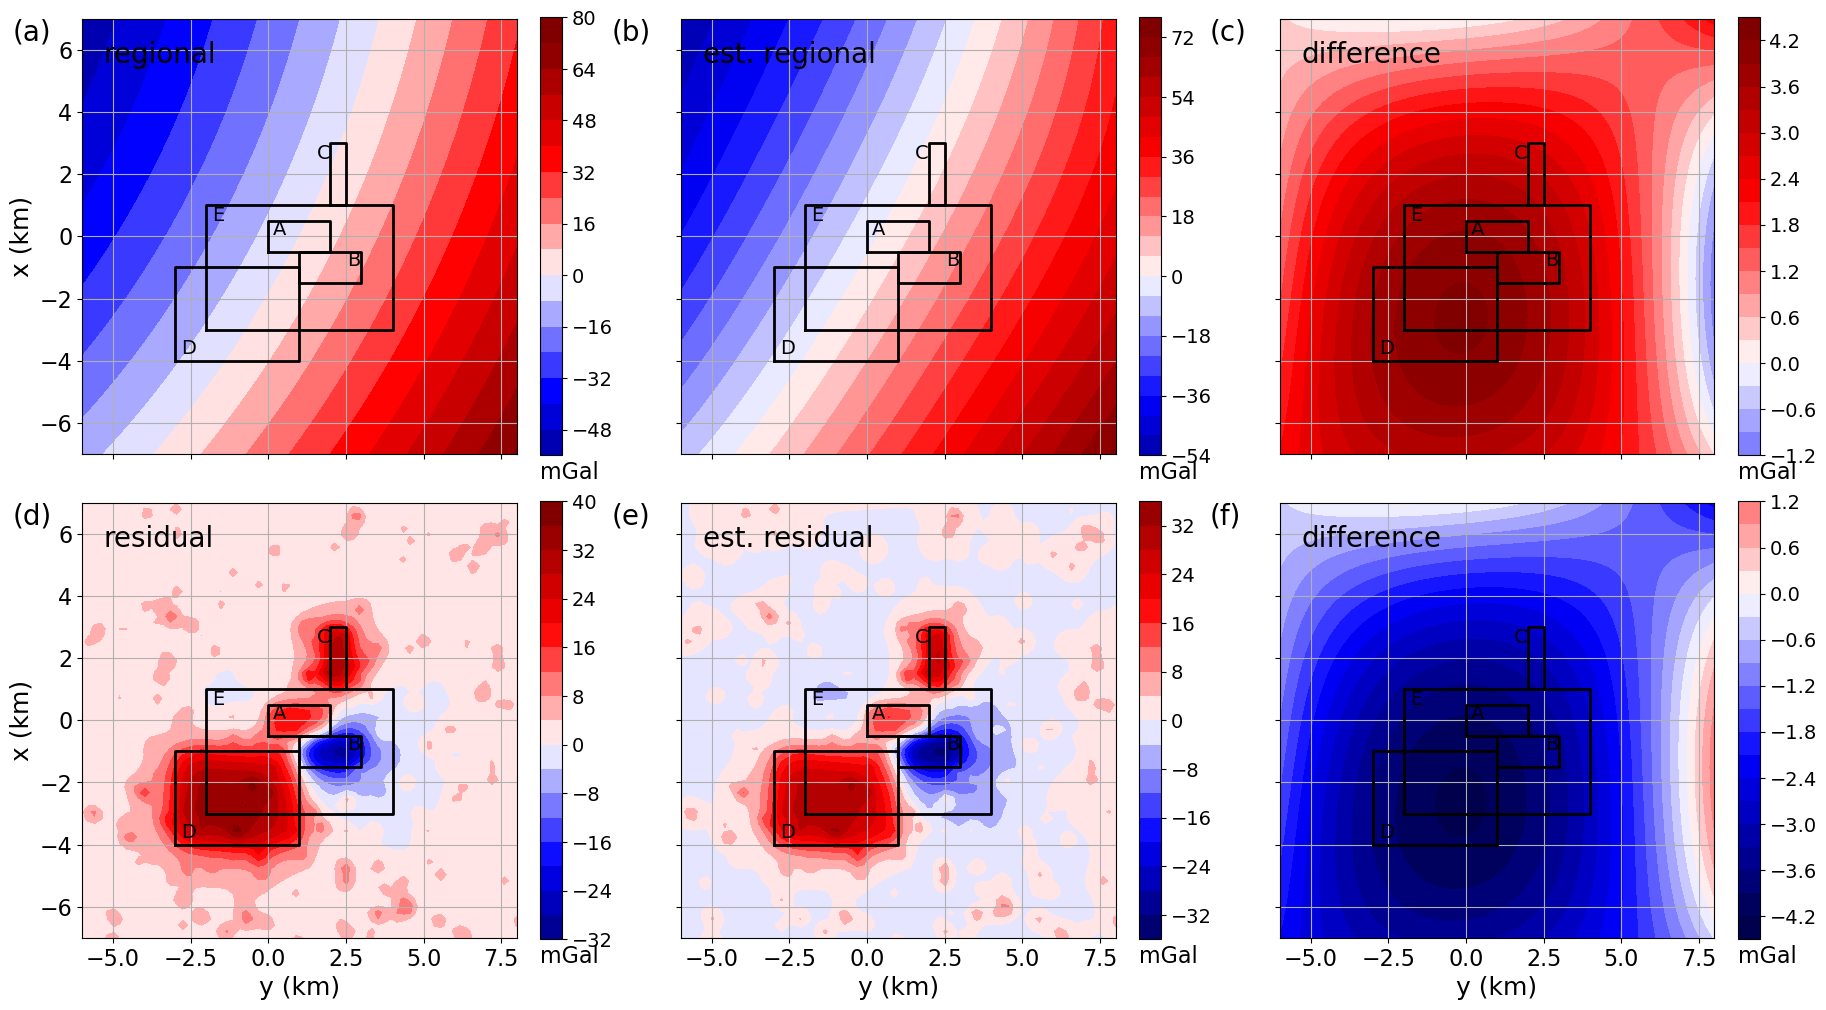

In [44]:
fig = plt.figure(layout= 'constrained', figsize=(18,10))
mosaic = fig.subplot_mosaic('''
                            abc
                            def
                            ''', sharex=True, sharey=True)

for (element, field, name, label, ranges_field) in zip(
    mosaic_elements, 
    [
        regional, estimated_regional2, estimated_regional2 - regional,
        gravity_data['gz'], estimated_residual2, estimated_residual2 - gravity_data['gz']
    ], 
    names, 
    labels,
    ranges
):

    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.contourf(Y*0.001, X*0.001, 
                     data_structures.grid_xy_full_flatten_to_matrix(
                         data=field,
                         grid_orientation=gravity_data['grid_orientation'],
                         shape=data_points['shape']
                     ), 20, 
                     cmap='seismic', vmin=-ranges_field, vmax=ranges_field)
    cb = fig.colorbar(im, ax=ax)
    cb.ax.tick_params(labelsize=14)
    cb.ax.set_xlabel('mGal', fontsize=16, loc='left')
    ax.set_ylim(0.001*data_points['area'][0], 0.001*data_points['area'][1])
    ax.set_xlim(0.001*data_points['area'][2], 0.001*data_points['area'][3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)
    ax.annotate(name, xy=(0.05, 0.90), xycoords='axes fraction', fontsize=20)
    plf.model_boundaries(
        ax,
        model=model_cut(model['prisms'], pmin=0, pmax=4),
        color=color,
        style='-',
        width='2'
    )
    ax.annotate(text='A', xy=(0.15, 0.05), fontsize=14, color=color)
    ax.annotate(text='B', xy=(2.55, -0.95), fontsize=14, color=color)
    ax.annotate(text='C', xy=(1.55, 2.50), fontsize=14, color=color)
    ax.annotate(text='D', xy=(-2.80, -3.80), fontsize=14, color=color)
    ax.annotate(text='E', xy=(-1.80, 0.50), fontsize=14, color=color)

for element in ['a', 'd']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)

for element in ['d','e','f']:
    mosaic[element].set_xlabel('y (km)', fontsize=18)

plt.show()